Setup and Library Installation

In [1]:
!pip install ibm-watsonx-ai pandas --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 35.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.6/139.6 kB 12.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 65.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 117.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 kB 6.4 MB/s eta 0:00:00
  Created wheel for ibm-cos-sdk: filename=ibm_cos_sdk-2.14.2-py3-none-any.whl size=77232 sha256=8a156c5c04586b3402e22b8727f418192dcf33a6ba3af1023fccfbb21859df8c
  Stored in directory: /root/.cache/pip/wheels/13/5a/01/6bac5df412055795d0f8732b5

Sentiment Analysis Code

In [2]:
import pandas as pd
import time # for delays
from ibm_watsonx_ai.foundation_models import ModelInference
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames
from google.colab import files # For direct download
from google.colab import drive # For Google Drive mounting

# Google Drive Mounting
output_drive_path = None
print("Mounting Google Drive (optional)...")
try:
    drive.mount('/content/drive')
    print("Google Drive mounted.")
    output_drive_path = '/content/drive/MyDrive/Colab_Results/legal_docs_with_sentiment.csv'
except Exception as e:
    print(f"Error mounting Google Drive: {e}. Skipping Google Drive save.")


# IBM Cloud credentials and project ID
api_key = "nBi9LKRmzW6QpCH_jlPsRE17rouOe_dUlOd-vW0G1an2"
project_id = "da405b88-a4e7-4fa6-a8eb-636c33559560"
region = "eu-de"
model_id = "google/flan-t5-xl"
credentials = {
    "url": f"https://{region}.ml.cloud.ibm.com",
    "apikey": api_key
}

# Inference parameters for deterministic output
gen_params = {
    GenTextParamsMetaNames.DECODING_METHOD: "greedy",
    GenTextParamsMetaNames.TEMPERATURE: 0
}

# ModelInference object
model = ModelInference(
    model_id=model_id,
    project_id=project_id,
    credentials=credentials,
    params=gen_params
)

def classify_sentiment(text):
    # refined few-shot prompt
    prompt = f"""Classify the sentiment of the following legal text as Positive, Negative, or Neutral.

    Text: "The appellate court affirmed the lower court's decision, finding no error in the original judgment."
    Sentiment: Positive

    Text: "The motion for summary judgment was denied, indicating the need for further litigation."
    Sentiment: Negative

    Text: "The contract contains standard boilerplate language, typical for such agreements."
    Sentiment: Neutral

    Text: "{text}"
    Sentiment:"""
    try:
        result = model.generate_text(prompt)
        time.sleep(0.1) # Small delay for individual API calls
        return result.strip()
    except Exception as e:
        print(f"Error classifying text: '{text[:100]}...' Error: {e}")
        time.sleep(0.5)
        return "Error"

# Load CSV file from Colab's session storage
try:
    df = pd.read_csv("legal_docs.csv")
    print("legal_docs.csv loaded successfully from Colab session storage!")
    print("\nOriginal DataFrame head:")
    print(df.head())
except FileNotFoundError:
    print("Error: legal_docs.csv not found in Colab session storage.")
    print("Please ensure you have uploaded 'legal_docs.csv' via the 'Files' tab.")
    exit()

# Apply sentiment classification to the 'Phrase' column in chunks
print("\nApplying sentiment classification to the 'Phrase' column in chunks...")
sentiment_results = []
chunk_size = 50
total_rows = len(df)

if 'Phrase' in df.columns:
    for i in range(0, total_rows, chunk_size):
        chunk = df.iloc[i:min(i+chunk_size, total_rows)] # Get the current chunk
        print(f"Processing chunk {i // chunk_size + 1} of {total_rows // chunk_size + (1 if total_rows % chunk_size > 0 else 0)} (rows {i}-{min(i+chunk_size, total_rows) - 1})...")

        # Apply sentiment to the current chunk's 'Phrase' column
        chunk_sentiments = chunk['Phrase'].apply(classify_sentiment)
        sentiment_results.extend(chunk_sentiments)

        # Add a longer pause between chunks to release resources and avoid rate limits
        if i + chunk_size < total_rows: # Don't sleep after the last chunk
            time.sleep(2) # Pause for 2 seconds between chunks

    df['Sentiment'] = sentiment_results # Assign all collected sentiments back to the 'Sentiment' column
    print("Sentiment classification complete for all data.")
else:
    print("Error: 'Phrase' column not found in DataFrame. Please check your CSV file's header.")
    exit()

output_filename = "legal_docs_with_sentiment.csv"

# Save results to a new CSV file and to Colab's session storage first
df.to_csv(output_filename, index=False)
print(f"\nResults saved to Colab session storage: {output_filename}")


# Download the file (Direct browser download)
try:
    files.download(output_filename)
    print(f"Download of {output_filename} initiated. Check your browser's downloads.")
except Exception as e:
    print(f"Error initiating direct download: {e}")
    print("You may need to manually download from the 'Files' tab on the left sidebar.")


# Save to Google Drive (If Google Drive mounting was successful)
if output_drive_path:
    try:
        print(f"Also saving results to Google Drive at: {output_drive_path}")
        df.to_csv(output_drive_path, index=False)
        print("Results saved to Google Drive.")
    except Exception as e:
        print(f"Error saving to Google Drive: {e}")
        print("Ensure Google Drive is mounted correctly and you have write permissions.")


# Sample to verify
print("\nFinal DataFrame head (with Sentiment):")
print(df.head())

Mounting Google Drive (optional)...
Mounted at /content/drive
Google Drive mounted.


/usr/local/lib/python3.11/dist-packages/ibm_watsonx_ai/foundation_models/utils/utils.py:436: LifecycleWarning: Model 'google/flan-t5-xl' is in deprecated state from 2025-06-18 until 2025-10-15. IDs of alternative models: None. Further details: https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/fm-model-lifecycle.html?context=wx&audience=wdp
  warn(model_state_warning, category=LifecycleWarning)


legal_docs.csv loaded successfully from Colab session storage!

Original DataFrame head:
   ID                                         Phrase  Sentiment
0   1          The plaintiff's claims are dismissed.         -1
1   2  The contract is deemed valid and enforceable.          1
2   3     The appeal is denied due to lack of merit.         -1
3   4  The legal team submitted additional evidence.          0
4   5             The appeal is under consideration.          0

Applying sentiment classification to the 'Phrase' column in chunks...
Processing chunk 1 of 10 (rows 0-49)...
Processing chunk 2 of 10 (rows 50-99)...
Processing chunk 3 of 10 (rows 100-149)...
Processing chunk 4 of 10 (rows 150-199)...
Processing chunk 5 of 10 (rows 200-249)...
Processing chunk 6 of 10 (rows 250-299)...
Processing chunk 7 of 10 (rows 300-349)...
Processing chunk 8 of 10 (rows 350-399)...
Processing chunk 9 of 10 (rows 400-449)...
Processing chunk 10 of 10 (rows 450-499)...
Sentiment classification compl

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download of legal_docs_with_sentiment.csv initiated. Check your browser's downloads.
Also saving results to Google Drive at: /content/drive/MyDrive/Colab_Results/legal_docs_with_sentiment.csv
Error saving to Google Drive: Cannot save file into a non-existent directory: '/content/drive/MyDrive/Colab_Results'
Ensure Google Drive is mounted correctly and you have write permissions.

Final DataFrame head (with Sentiment):
   ID                                         Phrase Sentiment
0   1          The plaintiff's claims are dismissed.  Negative
1   2  The contract is deemed valid and enforceable.  Positive
2   3     The appeal is denied due to lack of merit.  Negative
3   4  The legal team submitted additional evidence.  Positive
4   5             The appeal is under consideration.   Neutral


Generate Summarized Insights and Visualization


--- Summarized Sentiment Insights ---
Sentiment Distribution:
Sentiment
Positive    211
Negative    167
Neutral     122
Name: count, dtype: int64

Total documents analyzed: 500

Sentiment Percentage Distribution:
Sentiment
Positive    42.2
Negative    33.4
Neutral     24.4
Name: proportion, dtype: float64

--- Visualizing Sentiment Distribution ---


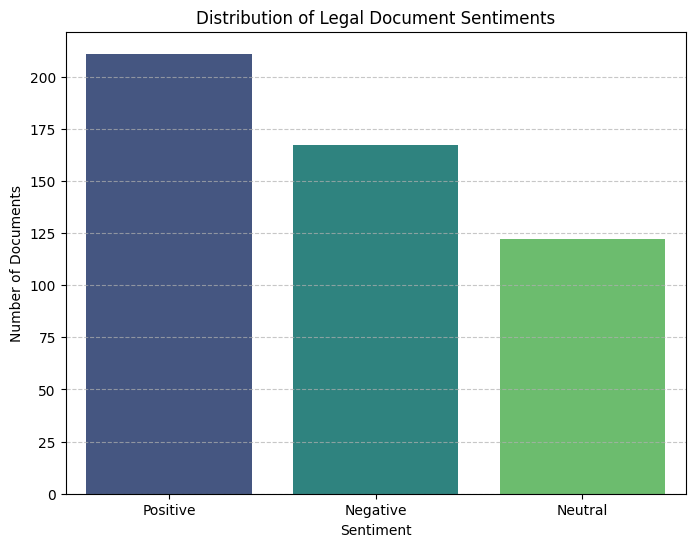

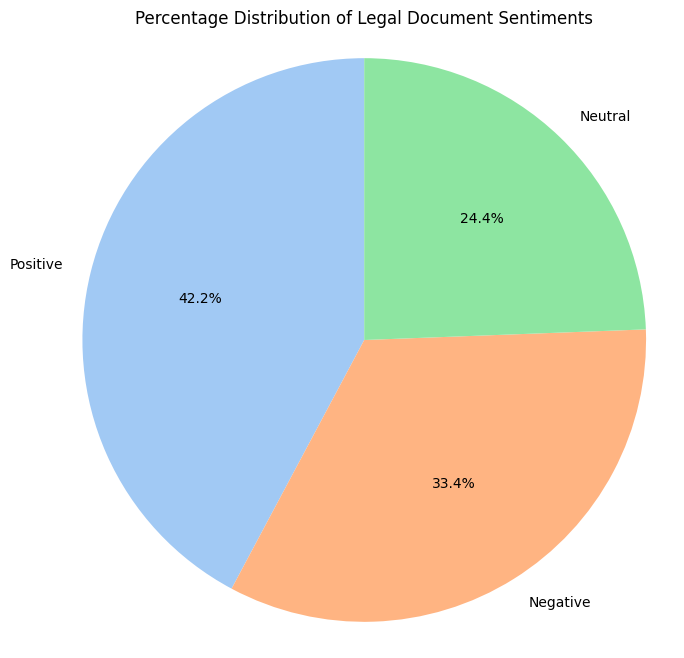


--- Sentiment Distribution Report ---
Sentiment  | Count    | Percentage
-----------------------------------
Positive   | 211      | 42.20    %
Negative   | 167      | 33.40    %
Neutral    | 122      | 24.40    %
-----------------------------------
Total      | 500      | 100.00   %

Summarized insights and visualizations generated.


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Generate Summarized Insights (Sentiment Counts)
print("\n--- Summarized Sentiment Insights ---")
sentiment_counts = df['Sentiment'].value_counts()
print("Sentiment Distribution:")
print(sentiment_counts)
print(f"\nTotal documents analyzed: {len(df)}")

# Calculate percentages
sentiment_percentages = df['Sentiment'].value_counts(normalize=True) * 100
print("\nSentiment Percentage Distribution:")
print(sentiment_percentages.round(2)) # Round to 2 decimal places

# Visualize the Sentiment Distribution
print("\n--- Visualizing Sentiment Distribution ---")

plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
plt.title('Distribution of Legal Document Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Number of Documents')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Pie chart for percentages
plt.figure(figsize=(8, 8))
plt.pie(sentiment_percentages, labels=sentiment_percentages.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('Percentage Distribution of Legal Document Sentiments')
plt.axis('equal')
plt.show()

# Distribution Report
print("\n--- Sentiment Distribution Report ---")
print(f"{'Sentiment':<10} | {'Count':<8} | {'Percentage':<10}")
print("-" * 35)
for sentiment, count in sentiment_counts.items():
    percentage = sentiment_percentages[sentiment]
    print(f"{sentiment:<10} | {count:<8} | {percentage:<9.2f}%")
print("-" * 35)
print(f"{'Total':<10} | {len(df):<8} | {100.00:<9.2f}%")


print("\nSummarized insights and visualizations generated.")